In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [9]:
# Load the datasets
train_data = pd.read_csv('train_aWnotuB.csv')
train_data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [10]:
test_data = pd.read_csv('datasets_8494_11879_test_BdBKkAj.csv')
test_data.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


In [3]:
# Check for missing values
print(train_data.isnull().sum())
print(test_data.isnull().sum())

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64
DateTime    0
Junction    0
ID          0
dtype: int64


In [4]:
# Convert DateTime to datetime format
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

# Feature extraction: Extract hour, day, month, and year from DateTime
train_data['Hour'] = train_data['DateTime'].dt.hour
train_data['Day'] = train_data['DateTime'].dt.day
train_data['Month'] = train_data['DateTime'].dt.month
train_data['Year'] = train_data['DateTime'].dt.year

test_data['Hour'] = test_data['DateTime'].dt.hour
test_data['Day'] = test_data['DateTime'].dt.day
test_data['Month'] = test_data['DateTime'].dt.month
test_data['Year'] = test_data['DateTime'].dt.year

In [5]:
# Features and target variable
X = train_data[['Junction', 'Hour', 'Day', 'Month', 'Year']]
y = train_data['Vehicles']

In [6]:
# One-hot encode categorical features
X_train_encoded = pd.get_dummies(X, columns=['Junction'], drop_first=True)
test_data_encoded = pd.get_dummies(test_data[['Junction', 'Hour', 'Day', 'Month', 'Year']], drop_first=True)

In [7]:
# Align test data with train data columns (fill missing columns with 0)
test_data_encoded = test_data_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [8]:
# Split the training data for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.3, random_state=42)

In [9]:
# Scale the features (for SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_data_encoded)

In [10]:
# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],  # Reduced range
    'gamma': [0.01, 0.1, 'scale'],  # Limited gamma values
    'epsilon': [0.01, 0.1]  # Fewer epsilon values
}

In [11]:
# Perform Randomized Search for SVM
svr = SVR(kernel='rbf')
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_grid_svm, n_iter=8, cv=6,scoring='r2', verbose=2, n_jobs=-1, random_state=42)
random_search_svr.fit(X_train_scaled, y_train)

Fitting 6 folds for each of 8 candidates, totalling 48 fits


RandomizedSearchCV(cv=6, estimator=SVR(), n_iter=8, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'epsilon': [0.01, 0.1],
                                        'gamma': [0.01, 0.1, 'scale']},
                   random_state=42, scoring='r2', verbose=2)

In [12]:
# Get the best parameters for SVM
best_params_svr = random_search_svr.best_params_
print(f"Best Parameters for SVM: {best_params_svr}")

Best Parameters for SVM: {'gamma': 0.1, 'epsilon': 0.1, 'C': 10}


In [13]:
# Train the final SVM model with the best parameters
best_svr = SVR(kernel='rbf', C=best_params_svr['C'], gamma=best_params_svr['gamma'], epsilon=best_params_svr['epsilon'])
best_svr.fit(X_train_scaled, y_train)

SVR(C=10, gamma=0.1)

In [14]:
# Predictions from SVM
y_val_pred_svr = best_svr.predict(X_val_scaled)
y_test_pred_svr = best_svr.predict(X_test_scaled)

In [15]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=15, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# Predictions from XGBoost
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

In [17]:
# Combine the predictions as new features for a meta-model (stacking)
X_val_combined = np.column_stack((y_val_pred_svr, y_val_pred_xgb))
X_test_combined = np.column_stack((y_test_pred_svr, y_test_pred_xgb))

In [18]:
# Train a meta-learner (Ridge Regression)
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_val_combined, y_val)

Ridge()

In [19]:
# Final predictions (ensemble)
y_val_meta_pred = meta_model.predict(X_val_combined)
y_test_meta_pred = meta_model.predict(X_test_combined)

In [20]:
# Evaluate the meta-learner
mae_meta = mean_absolute_error(y_val, y_val_meta_pred)
r2_meta = r2_score(y_val, y_val_meta_pred)
rmse_meta = np.sqrt(mean_squared_error(y_val, y_val_meta_pred))
msle_meta = mean_squared_log_error(y_val, y_val_meta_pred)

print(f'Mean Absolute Error (Meta-Learner): {mae_meta}')
print(f'R² Score (Meta-Learner): {r2_meta}')
print(f'Root Mean Squared Error (Meta-Learner): {rmse_meta}')
print(f'Mean Squared Log Error (Meta-Learner): {msle_meta}')

Mean Absolute Error (Meta-Learner): 2.8968522603003777
R² Score (Meta-Learner): 0.9514023257711671
Root Mean Squared Error (Meta-Learner): 4.4849103287218774
Mean Squared Log Error (Meta-Learner): 0.05332894286977901


In [21]:
# Cross-validate the meta-model
cross_val_r2_scores = cross_val_score(meta_model, X_val_combined, y_val, cv=5, scoring='r2')
print(f'Cross-validated R² scores: {cross_val_r2_scores}')

Cross-validated R² scores: [0.94714854 0.93725506 0.95608752 0.96263107 0.95170854]


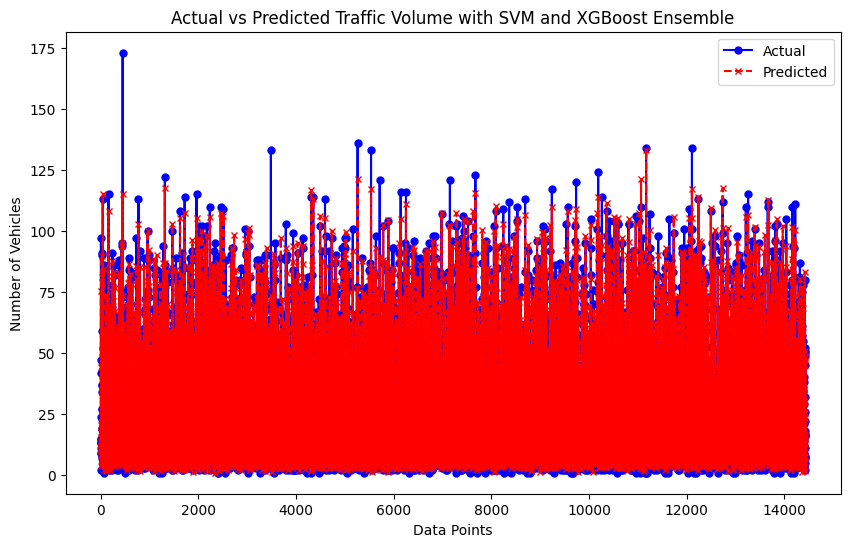

In [22]:
# Visualize actual vs predicted values for the validation set (Meta-Learner)
plt.figure(figsize=(10, 6))
plt.plot(y_val.values, label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(y_val_meta_pred, label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
plt.title('Actual vs Predicted Traffic Volume with SVM and XGBoost Ensemble')
plt.xlabel('Data Points')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

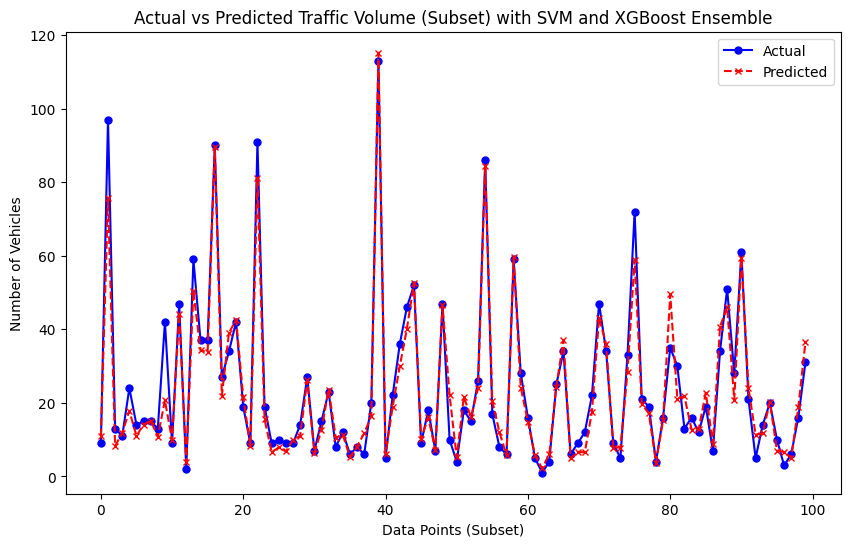

In [23]:
# Visualize actual vs predicted values for the validation set (Meta-Learner)
plt.figure(figsize=(10, 6))
plt.plot(y_val.values[:100], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(y_val_meta_pred[:100], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
plt.title('Actual vs Predicted Traffic Volume (Subset) with SVM and XGBoost Ensemble')
plt.xlabel('Data Points (Subset)')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [24]:
# Save the test predictions
test_data['Predicted_Vehicles'] = y_test_meta_pred
test_data.to_csv('test_predictions_with_svm_xgboost_ensemble.csv', index=False)

In [25]:
# Save the meta-model for future use
joblib.dump(meta_model, 'meta_model_svr_xgboost.pkl')

['meta_model_svr_xgboost.pkl']

In [26]:
joblib.dump(best_svr, 'best_svr_model.pkl')

['best_svr_model.pkl']

In [27]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [28]:
#joblib.dump(meta_model, 'meta_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']